<a href="https://colab.research.google.com/github/bluetinue/sharehouse/blob/main/CountryName.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 人名分类器


In [ ]:
#@title 导包
# prompt: 装载谷歌硬盘
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
# 显示所有变量
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# 导入torch工具
import torch
# 导入nn准备构建模型
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# 导入torch的数据源 数据迭代器工具包
from  torch.utils.data import Dataset, DataLoader
# 用于获得常见字母及字符规范化
import string
# 导入时间工具包
import time
# 引入制图工具包
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# @title 读取数据
data = pd.read_csv('/content/drive/MyDrive/NLP/data/name_classfication.txt',sep='\t')

In [ ]:
# @title 数据预处理

#去重后的词表
all_letters = string.ascii_letters + " ,.:'"
n_letters = len(all_letters)
# 国家名 种类数
categorys = ['Italian', 'English', 'Arabic', 'Spanish', 'Scottish', 'Irish', 'Chinese', 'Vietnamese', 'Japanese',
             'French', 'Greek', 'Dutch', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Czech', 'German']
# 国家名 个数
categorynum = len(categorys)
print('categorys--->', categorys)
print('all_letters--->', all_letters)

# 读取数据
def read_data(path):
  x,y = [],[]
  with open(path,'r') as f:
    lines = f.readlines()
    for line in lines:
      line = line.strip().split('\t')
      x.append(line[0])
      y.append(line[1])
  return x,y

categorys---> ['Italian', 'English', 'Arabic', 'Spanish', 'Scottish', 'Irish', 'Chinese', 'Vietnamese', 'Japanese', 'French', 'Greek', 'Dutch', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Czech', 'German']
all_letters---> abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ ,.:'


In [ ]:
#@title 数据加载器
#定义数据封装器类
class NameclassifcationDataset(Dataset):
    def __init__(self,x,y):
      #将读取的数据封装起来
        self.x = x
        self.y = y
        self.sample_len = len(x)

    #调用len方法返回x的数量
    def __len__(self):
        return self.sample_len

    #对进行切片操作时调用
    def __getitem__(self, idx):
      idx = min(max(0,idx),self.sample_len-1)

      x = self.x[idx]
      y = self.y[idx]

      tensor_x = torch.zeros(len(x),n_letters)
      for i,v in enumerate(x):
        tensor_x[i][all_letters.find(v)] = 1

      tensor_y = torch.tensor(categorys.index(y))

      return tensor_x,tensor_y

In [ ]:
#@title 迭代器
def get_traindata():
  path = "/content/drive/MyDrive/NLP/data/name_classfication.txt"
  x,y = read_data(path)
  nameclassdataset = NameclassifcationDataset(x,y)
  train_loader = DataLoader(nameclassdataset,batch_size=1,shuffle=True)
  for x,y in train_loader:
    print(x.shape,y.shape)
    break
  return train_loader

In [ ]:
#@title 构建RNN
# RNN类 实现思路分析：
# 1 init函数 准备三个层 self.rnn self.linear self.softmax=nn.LogSoftmax(dim=-1)
#    def __init__(self, input_size, hidden_size, output_size, num_layers=1)

# 2 forward(input, hidden)函数
#   让数据经过三个层 返回softmax结果和hn
#   形状变化 [seqlen,1,57],[1,1,128]) -> [seqlen,1,128],[1,1,128]

# 3 初始化隐藏层输入数据 inithidden()
#   形状[self.num_layers, 1, self.hidden_size]
class myRNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_layers=1):
    super(myRNN, self).__init__()
    self.input_size = input_size
    self.num_layers = num_layers
    self.hidden_size = hidden_size
    self.output_size = output_size

    self.rnn = nn.RNN(input_size, hidden_size, num_layers)
    self.out = nn.Linear(hidden_size, output_size)
    # #根据后边的损失函数如果是CrossEntropyLoss,就不需要softmax，是NLLLoss就需要加上softmax
    # self.softmax = nn.LogSoftmax(dim=-1)

  #前向传播
  def forward(self,input,hidden):
    #input
    input = input.unsqueeze(1)

    rr,hn = self.rnn(input,hidden)
    tmprr = rr[-1]
    tmprr = self.out(tmprr)
    return tmprr,hn

  #初始化隐藏层输入数据
  def inithidden(self):
    return torch.zeros(self.num_layers, 1, self.hidden_size)


In [ ]:
#@title 构建LSTM
# LSTM类 实现思路分析：
# 1 init函数 准备三个层 self.rnn self.linear self.softmax=nn.LogSoftmax(dim=-1)
#    def __init__(self, input_size, hidden_size, output_size, num_layers=1)

# 2 forward(input, hidden)函数
#   让数据经过三个层 返回softmax结果和hn
#   形状变化 [seqlen,1,57],[1,1,128]) -> [seqlen,1,128],[1,1,128]

# 3 初始化隐藏层输入数据 inithidden()
#   形状[self.num_layers, 1, self.hidden_size]
class myLSTM(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_layers=1):
    super().__init__()
    self.input_size = input_size
    self.num_layers = num_layers
    self.hidden_size = hidden_size
    self.output_size = output_size

    self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
    self.out = nn.Linear(hidden_size, output_size)
    #根据后边的损失函数如果是CrossEntropyLoss,就不需要softmax，是NLLLoss就需要加上softmax
    self.softmax = nn.LogSoftmax(dim=-1)

  #前向传播
  def forward(self,input,hidden,c):
    #input
    input = input.unsqueeze(1)

    rr,(hn,cn) = self.lstm(input,(hidden,c))
    tmprr = rr[-1]
    tmprr = self.out(tmprr)
    return self.softmax(tmprr),hn,cn

  #初始化隐藏层输入数据
  def inithidden(self):
    hidden = c = torch.zeros(self.num_layers, 1, self.hidden_size)
    return hidden,c


In [ ]:
#@title 构建GRU
# GRU类 实现思路分析：
# 1 init函数 准备三个层 self.rnn self.linear self.softmax=nn.LogSoftmax(dim=-1)
#    def __init__(self, input_size, hidden_size, output_size, num_layers=1)

# 2 forward(input, hidden)函数
#   让数据经过三个层 返回softmax结果和hn
#   形状变化 [seqlen,1,57],[1,1,128]) -> [seqlen,1,128],[1,1,128]

# 3 初始化隐藏层输入数据 inithidden()
#   形状[self.num_layers, 1, self.hidden_size]
class myGRU(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_layers=1):
    super().__init__()
    self.input_size = input_size
    self.num_layers = num_layers
    self.hidden_size = hidden_size
    self.output_size = output_size

    self.rnn = nn.GRU(input_size, hidden_size, num_layers)
    self.out = nn.Linear(hidden_size, output_size)
    #根据后边的损失函数如果是CrossEntropyLoss,就不需要softmax，是NLLLoss就需要加上softmax
    self.softmax = nn.LogSoftmax(dim=-1)

  #前向传播
  def forward(self,input,hidden):
    #input
    input = input.unsqueeze(1)

    rr,hn = self.rnn(input,hidden)
    tmprr = rr[-1]
    tmprr = self.out(tmprr)
    return self.softmax(tmprr),hn

  #初始化隐藏层输入数据
  def inithidden(self):
    return torch.zeros(self.num_layers, 1, self.hidden_size)


In [ ]:
#@title 思路分析
# 从文件获取数据、实例化数据源对象nameclassdataset 数据迭代器对象mydataloader
# 实例化模型对象my_rnn 损失函数对象mycrossentropyloss=nn.NLLLoss() 优化器对象myadam
# 定义模型训练的参数
#       starttime total_iter_num total_loss  total_loss_list total_acc_num  total_acc_list
# 外层for循环 控制轮数 for epoch_idx in range(epochs)
# 内层for循环 控制迭代次数 for i, (x, y) in enumerate(mydataloader)
    # 给模型喂数据   # 计算损失  # 梯度清零 # 反向传播  # 梯度更新
    # 计算辅助信息   # 累加总损失和准确数 每100次训练计算一个总体平均损失 总体平均准确率 每2000次训练 打印日志
    # 其他          # 预测对错 i_predit_tag = (1 if torch.argmax(output).item() == y.item() else 0)

# 模型保存
    # torch.save(my_rnn.state_dict(), './my_rnn_model_%d.bin' % (epoch_idx + 1))
# 返回 平均损失列表total_loss_list, 时间total_time, 平均准确total_acc_list

In [ ]:
# 检查是否有可用的CUDA设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

epochs = 1
lr = 1e-3
def train_rnn():
  #实例化dataloader
  rnn_dataloader = get_traindata()
  #实例化模型
  input_size = all_letters
  hidden_size = 200
  output_size = categorynum
  my_rnn = myRNN(input_size=n_letters,
                 hidden_size=hidden_size,
                 output_size=categorynum).to(device=device)

  #损失函数和优化器
  myloss = nn.NLLLoss()
  myoptimizer = optim.Adam(my_rnn.parameters(), lr=lr)

  #训练日志参数
  starttime = time.time()
  total_iter_num = 0 #已经训练的样本数
  total_loss = 0  #已经训练的损失和
  total_loss_list = [] #每批样本求一次平均损失
  total_acc_num = 0 #训练样本准确总数
  total_acc_list = [] #平均准确率列表

  #开始训练


  #前向传播


Using device: cuda


In [ ]:
from tqdm import tqdm
import json

In [20]:
#@title RNN训练
# 检查是否有可用的CUDA设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

lr = 1e-4
epochs = 10
path = "/content/drive/MyDrive/NLP/data/name_classfication.txt"
x,y = read_data(path)
def train_rnn(x,y):
  #实例化dataloader

  input_size = all_letters
  hidden_size = 200
  output_size = categorynum
  #实例化模型
  my_rnn = myRNN(input_size=n_letters,
                 hidden_size=hidden_size,
                 output_size=categorynum).to(device) # 将模型移动到GPU

  loss_fn = nn.CrossEntropyLoss()
  optimizer = optim.Adam(my_rnn.parameters(), lr=lr)

  starttime = time.time()
  total_iter_num = 0 #已经训练的样本数
  total_loss = 0  #已经训练的损失和
  total_loss_list = [] #每批样本求一次平均损失
  total_acc_num = 0 #训练样本准确总数
  total_acc_list = [] #平均准确率列表

  for epoch in range(epochs):
    namedataloader = get_traindata()
    for i,(x,y) in enumerate(tqdm(namedataloader)):
      x,y = x.to(device), y.to(device) # 将数据移动到GPU
      hidden = my_rnn.inithidden().to(device) # 将隐藏层初始化数据移动到GPU
      output,hidden = my_rnn(x[0],hidden)
      loss = loss_fn(output,y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      #计算损失
      total_iter_num = total_iter_num + 1
      total_loss = total_loss + loss.item()
      #计算准确率
      i_predit_tag = (1 if torch.argmax(output).item() == y.item() else 0)
      total_acc_num = total_acc_num + i_predit_tag
      #每100次训练计算一次平均损失
      if (total_iter_num % 100 == 0):
        tmploss = total_loss / total_iter_num
        total_loss_list.append(tmploss)

        tmpacc = total_acc_num / total_iter_num
        total_acc_list.append(tmpacc)
      #每1000次训练打印日志
      if (total_iter_num % 1000 == 0):
        total_time = time.time() - starttime
        print(f'轮次{epoch+1},损失{tmploss:.6f},\
        时间{time.time()-starttime:.6f},准确率{tmpacc:.6f}')
    #保存训练好的模型
    torch.save(my_rnn.state_dict(), '/content/drive/MyDrive/NLP/model/my_rnn_model.bin')
  #计算总时间
  total_time = int(time.time() - starttime)
  rnn_dict = {"total_loss_list":total_loss_list,"total_time":total_time,"total_acc_list":total_acc_list}
  with open('/content/drive/MyDrive/NLP/model/rnn_dict.json','w') as f:
    f.write(json.dumps(rnn_dict))



total_loss_list, total_time, total_acc_list = train_rnn(x,y)

Using device: cpu
torch.Size([1, 5, 57]) torch.Size([1])


  5%|▌         | 1040/20074 [00:03<01:04, 295.46it/s]

轮次1,损失1.860180,        时间3.261884,准确率0.452000


 10%|█         | 2073/20074 [00:06<00:44, 403.51it/s]

轮次1,损失1.789155,        时间6.148377,准确率0.466000


 15%|█▌        | 3066/20074 [00:08<00:40, 418.76it/s]

轮次1,损失1.728591,        时间8.578168,准确率0.483667


 20%|██        | 4041/20074 [00:11<00:39, 403.82it/s]

轮次1,损失1.669715,        时间11.041132,准确率0.501750


 25%|██▌       | 5060/20074 [00:14<00:46, 319.67it/s]

轮次1,损失1.645673,        时间13.873472,准确率0.511200


 30%|██▉       | 6019/20074 [00:18<01:22, 170.81it/s]

轮次1,损失1.606115,        时间18.738261,准确率0.525000


 35%|███▌      | 7073/20074 [00:22<00:31, 409.46it/s]

轮次1,损失1.576755,        时间22.754442,准确率0.533000


 40%|████      | 8042/20074 [00:25<00:29, 408.31it/s]

轮次1,损失1.557948,        时间25.217264,准确率0.539250


 45%|████▌     | 9057/20074 [00:27<00:26, 414.77it/s]

轮次1,损失1.526134,        时间27.675641,准确率0.550444


 50%|█████     | 10054/20074 [00:30<00:25, 392.39it/s]

轮次1,损失1.493228,        时间30.195206,准确率0.560300


 55%|█████▍    | 11035/20074 [00:33<00:32, 278.46it/s]

轮次1,损失1.469747,        时间33.305951,准确率0.568545


 60%|██████    | 12061/20074 [00:36<00:19, 404.18it/s]

轮次1,损失1.446599,        时间36.363942,准确率0.577083


 65%|██████▌   | 13073/20074 [00:38<00:17, 403.98it/s]

轮次1,损失1.430045,        时间38.828990,准确率0.582923


 70%|███████   | 14083/20074 [00:41<00:15, 387.88it/s]

轮次1,损失1.411805,        时间41.446350,准确率0.587786


 75%|███████▍  | 15046/20074 [00:44<00:12, 392.29it/s]

轮次1,损失1.392475,        时间44.047415,准确率0.593600


 80%|███████▉  | 16048/20074 [00:47<00:13, 290.80it/s]

轮次1,损失1.372792,        时间47.167856,准确率0.598938


 85%|████████▍ | 17045/20074 [00:50<00:07, 399.08it/s]

轮次1,损失1.358160,        时间50.130175,准确率0.604353


 90%|████████▉ | 18047/20074 [00:52<00:04, 415.57it/s]

轮次1,损失1.350372,        时间52.622175,准确率0.606722


 95%|█████████▌| 19077/20074 [00:55<00:02, 395.20it/s]

轮次1,损失1.335361,        时间55.176993,准确率0.611632


100%|██████████| 20074/20074 [00:57<00:00, 347.09it/s]

轮次1,损失1.322687,        时间57.673105,准确率0.615250


torch.Size([1, 6, 57]) torch.Size([1])


  5%|▍         | 980/20074 [00:03<01:07, 281.00it/s]

轮次2,损失1.310181,        时间60.879695,准确率0.619381


 10%|▉         | 1969/20074 [00:06<00:45, 401.83it/s]

轮次2,损失1.301746,        时间63.777423,准确率0.621864


 12%|█▏        | 2352/20074 [00:06<00:52, 336.75it/s]


KeyboardInterrupt: 

In [23]:
#@title 构建LSTM
# LSTM类 实现思路分析：
# 1 init函数 准备三个层 self.rnn self.linear self.softmax=nn.LogSoftmax(dim=-1)
#    def __init__(self, input_size, hidden_size, output_size, num_layers=1)

# 2 forward(input, hidden)函数
#   让数据经过三个层 返回softmax结果和hn
#   形状变化 [seqlen,1,57],[1,1,128]) -> [seqlen,1,128],[1,1,128]

# 3 初始化隐藏层输入数据 inithidden()
#   形状[self.num_layers, 1, self.hidden_size]
class myLSTM(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_layers=1):
    super().__init__()
    self.input_size = input_size
    self.num_layers = num_layers
    self.hidden_size = hidden_size
    self.output_size = output_size

    self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
    self.out = nn.Linear(hidden_size, output_size)
    #根据后边的损失函数如果是CrossEntropyLoss,就不需要softmax，是NLLLoss就需要加上softmax
    self.softmax = nn.LogSoftmax(dim=-1)

  #前向传播
  def forward(self,input,hidden,c):
    #input
    input = input.unsqueeze(1)

    rr,(hn,cn) = self.lstm(input,(hidden,c))
    tmprr = rr[-1]
    tmprr = self.out(tmprr)
    return self.softmax(tmprr),hn,cn

  #初始化隐藏层输入数据
  def inithidden(self):
    hidden = c = torch.zeros(self.num_layers, 1, self.hidden_size)
    return hidden,c

#@title LSTM训练
lr = 1e-3
epochs = 1
path = "/content/drive/MyDrive/NLP/data/name_classfication.txt"
x,y = read_data(path)
def train_lstm(x,y):
  # 检查是否有可用的CUDA设备
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print(f"Using device: {device}")

  #实例化dataloader
  namedataloader = get_traindata()
  input_size = all_letters
  hidden_size = 200
  output_size = categorynum
  #实例化模型
  my_lstm = myLSTM(input_size=n_letters,
                 hidden_size=hidden_size,
                 output_size=categorynum).to(device) # 将模型移动到GPU

  loss_fn = nn.NLLLoss()
  optimizer = optim.Adam(my_lstm.parameters(), lr=lr)

  starttime = time.time()
  total_iter_num = 0 #已经训练的样本数
  total_loss = 0  #已经训练的损失和
  total_loss_list = [] #每批样本求一次平均损失
  total_acc_num = 0 #训练样本准确总数
  total_acc_list = [] #平均准确率列表

  for epoch in range(epochs):
    for i,(x,y) in enumerate(tqdm(namedataloader)):
      x,y = x.to(device), y.to(device) # 将数据移动到GPU
      hidden,c = [h.to(device) for h in my_lstm.inithidden()] # 将隐藏层初始化数据移动到GPU
      output,hidden,c = my_lstm(x[0],hidden,c)

      loss = loss_fn(output,y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      #计算损失
      total_iter_num = total_iter_num + 1
      total_loss = total_loss + loss.item()
      #计算准确率
      i_predit_tag = (1 if torch.argmax(output).item() == y.item() else 0)
      total_acc_num = total_acc_num + i_predit_tag
      #每100次训练计算一次平均损失
      if (total_iter_num % 100 == 0):
        tmploss = total_loss / total_iter_num
        total_loss_list.append(tmploss)

        tmpacc = total_acc_num / total_iter_num
        total_acc_list.append(tmpacc)
      #每1000次训练打印日志
      if (total_iter_num % 1000 == 0):
        total_time = time.time() - starttime
        print(f'轮次{epoch+1},损失{tmploss:.6f},\
        时间{time.time()-starttime:.6f},准确率{tmpacc:.6f}')
  #计算总时间
  total_time = int(time.time() - starttime)
  #保存训练好的模型
  torch.save(my_lstm.state_dict(), '/content/drive/MyDrive/NLP/model/my_lstm_model.bin')
  return total_loss_list, total_time, total_acc_list

total_lloss_list, total_ltime, total_lacc_list = train_lstm(x,y)

Using device: cpu
torch.Size([1, 4, 57]) torch.Size([1])


  5%|▌         | 1025/20074 [00:09<03:02, 104.18it/s]

轮次1,损失1.737767,        时间9.534594,准确率0.509000


 10%|█         | 2037/20074 [00:17<01:35, 189.30it/s]

轮次1,损失1.563396,        时间17.241881,准确率0.548000


 15%|█▌        | 3036/20074 [00:22<01:09, 245.76it/s]

轮次1,损失1.457996,        时间21.870001,准确率0.578667


 20%|██        | 4043/20074 [00:26<01:08, 232.71it/s]

轮次1,损失1.407697,        时间26.286271,准确率0.593750


 25%|██▌       | 5019/20074 [00:31<01:28, 169.47it/s]

轮次1,损失1.338276,        时间31.132523,准确率0.612600


 30%|███       | 6028/20074 [00:35<00:59, 236.96it/s]

轮次1,损失1.301529,        时间35.700770,准确率0.625167


 35%|███▍      | 7025/20074 [00:39<00:51, 254.48it/s]

轮次1,损失1.277482,        时间39.572700,准确率0.630714


 40%|████      | 8033/20074 [00:44<01:06, 180.88it/s]

轮次1,损失1.239893,        时间43.913609,准确率0.641500


 45%|████▌     | 9035/20074 [00:48<00:45, 243.51it/s]

轮次1,损失1.201158,        时间48.731739,准确率0.652000


 50%|█████     | 10050/20074 [00:53<00:40, 247.33it/s]

轮次1,损失1.184683,        时间52.893942,准确率0.656200


 55%|█████▍    | 11031/20074 [00:57<00:50, 178.65it/s]

轮次1,损失1.156620,        时间57.274162,准确率0.662818


 60%|█████▉    | 12030/20074 [01:02<00:34, 235.19it/s]

轮次1,损失1.132682,        时间62.305208,准确率0.669250


 65%|██████▍   | 13036/20074 [01:06<00:29, 241.07it/s]

轮次1,损失1.112167,        时间66.493114,准确率0.675077


 70%|██████▉   | 14029/20074 [01:10<00:33, 181.19it/s]

轮次1,损失1.093088,        时间70.542666,准确率0.680643


 75%|███████▍  | 15030/20074 [01:15<00:20, 246.55it/s]

轮次1,损失1.082291,        时间75.499632,准确率0.683333


 80%|███████▉  | 16035/20074 [01:19<00:15, 266.69it/s]

轮次1,损失1.063724,        时间79.560237,准确率0.688688


 85%|████████▍ | 17029/20074 [01:23<00:15, 202.29it/s]

轮次1,损失1.047681,        时间83.711107,准确率0.692941


 90%|████████▉ | 18036/20074 [01:29<00:10, 203.50it/s]

轮次1,损失1.033968,        时间89.019049,准确率0.696944


 95%|█████████▍| 19036/20074 [01:33<00:04, 243.81it/s]

轮次1,损失1.022919,        时间93.213511,准确率0.700000


100%|█████████▉| 20016/20074 [01:37<00:00, 218.01it/s]

轮次1,损失1.007444,        时间97.342026,准确率0.704250


100%|██████████| 20074/20074 [01:37<00:00, 205.39it/s]


Using device: cpu
torch.Size([1, 12, 57]) torch.Size([1])


  5%|▌         | 1039/20074 [00:04<01:19, 239.47it/s]

轮次1,损失1.703140,        时间4.530008,准确率0.509000


 10%|█         | 2031/20074 [00:08<01:16, 236.76it/s]

轮次1,损失1.574654,        时间8.683532,准确率0.541000


 15%|█▌        | 3023/20074 [00:13<01:48, 156.43it/s]

轮次1,损失1.486189,        时间13.115233,准确率0.565000


 20%|██        | 4034/20074 [00:18<01:11, 223.64it/s]

轮次1,损失1.405177,        时间17.890153,准确率0.586750


 25%|██▌       | 5039/20074 [00:22<01:01, 244.50it/s]

轮次1,损失1.361079,        时间22.080551,准确率0.601000


 30%|███       | 6026/20074 [00:26<01:14, 188.30it/s]

轮次1,损失1.316842,        时间26.218949,准确率0.610333


 35%|███▌      | 7047/20074 [00:31<00:52, 249.61it/s]

轮次1,损失1.290285,        时间31.029268,准确率0.617857


 40%|████      | 8032/20074 [00:35<00:48, 248.31it/s]

轮次1,损失1.251801,        时间35.046316,准确率0.630000


 45%|████▍     | 9029/20074 [00:39<00:59, 186.71it/s]

轮次1,损失1.218774,        时间39.245248,准确率0.640667


 50%|████▉     | 10022/20074 [00:44<00:45, 221.87it/s]

轮次1,损失1.195539,        时间44.339146,准确率0.646600


 55%|█████▌    | 11042/20074 [00:48<00:37, 238.18it/s]

轮次1,损失1.173511,        时间48.569052,准确率0.652455


 60%|█████▉    | 12026/20074 [00:53<00:44, 179.63it/s]

轮次1,损失1.155311,        时间52.962681,准确率0.658000


 65%|██████▍   | 13038/20074 [00:58<00:29, 234.96it/s]

轮次1,损失1.134407,        时间57.917574,准确率0.664615


 70%|██████▉   | 14048/20074 [01:02<00:24, 241.07it/s]

轮次1,损失1.114147,        时间62.191626,准确率0.670929


 75%|███████▍  | 15026/20074 [01:06<00:29, 172.84it/s]

轮次1,损失1.090571,        时间66.437815,准确率0.678600


 80%|███████▉  | 16036/20074 [01:11<00:15, 255.32it/s]

轮次1,损失1.074499,        时间71.308379,准确率0.683063


 85%|████████▍ | 17038/20074 [01:15<00:12, 240.69it/s]

轮次1,损失1.055264,        时间75.398255,准确率0.688176


 90%|████████▉ | 18012/20074 [01:20<00:14, 139.36it/s]

轮次1,损失1.044679,        时间80.799327,准确率0.691944


 95%|█████████▍| 19045/20074 [01:25<00:04, 241.42it/s]

轮次1,损失1.032111,        时间85.788054,准确率0.695526


100%|█████████▉| 20029/20074 [01:29<00:00, 259.64it/s]

轮次1,损失1.021177,        时间89.858221,准确率0.698950


100%|██████████| 20074/20074 [01:30<00:00, 222.69it/s]


In [ ]:
#@title 练习
class lstm(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_layers=1):
    super().__init__()
    self.input_size = input_size
    self.num_layers = num_layers
    self.hidden_size = hidden_size
    self.output_size = output_size
    #定义lstm层
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
    #定义线性层处理lstm层返回的数据 hidden_size,18
    self.liner = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=-1)

  def forward(self,input,hidden,c):
    input = input.unsqueeze(1)
    rr,(hn,cn) = self.lstm(input,(hidden,c))
    #取最后一个时间步的输出,然后经过线性层输出到softmax
    return self.softmax(self.liner(rr[-1])),hn,cn

  def inithidden(self):
    hidden  = torch.zeros(self.num_layers, 1, self.hidden_size)
    c = torch.zeros(self.num_layers, 1, self.hidden_size)
    return hidden,c

In [ ]:
#@title 测试结果
# 1 实例化rnn对象
mylstm = lstm(57, 128, 18)
print('lstm--->', mylstm)

# 2 准备数据
input = torch.randn(6, 57)
print(input.shape)
h,c = mylstm.inithidden()

# 3 给模型1次性的送数据
# [seqlen, 57], [1, 1, 128]) -> [1,18], [1,1,128]
output, h,c = mylstm(input, h,c)
print('一次性的送数据：output->', output.shape, output)
print('hidden->', h.shape)
print('outpur->', output.shape)


lstm---> lstm(
  (lstm): LSTM(57, 128)
  (liner): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=-1)
)
torch.Size([6, 57])
一次性的送数据：output-> torch.Size([1, 18]) tensor([[-2.8638, -2.9164, -2.9041, -2.8995, -2.8628, -2.8157, -2.9376, -2.7969,
         -2.8231, -2.8488, -3.0521, -3.0163, -2.7905, -2.8855, -3.0211, -2.7957,
         -2.9637, -2.8866]], grad_fn=<LogSoftmaxBackward0>)
hidden-> torch.Size([1, 1, 128])
outpur-> torch.Size([1, 18])


In [24]:
#@title GRU训练
lr = 1e-3
epochs = 1
path = "/content/drive/MyDrive/NLP/data/name_classfication.txt"
x,y = read_data(path)
def train_gru(x,y):
  # 检查是否有可用的CUDA设备
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print(f"Using device: {device}")

  #实例化dataloader
  namedataloader = get_traindata()
  input_size = all_letters
  hidden_size = 200
  output_size = categorynum
  #实例化模型
  my_gru = myGRU(input_size=n_letters,
                 hidden_size=hidden_size,
                 output_size=categorynum).to(device) # 将模型移动到GPU

  loss_fn = nn.NLLLoss()
  optimizer = optim.Adam(my_gru.parameters(), lr=lr)

  starttime = time.time()
  total_iter_num = 0 #已经训练的样本数
  total_loss = 0  #已经训练的损失和
  total_loss_list = [] #每批样本求一次平均损失
  total_acc_num = 0 #训练样本准确总数
  total_acc_list = [] #平均准确率列表

  for epoch in range(epochs):
    for i,(x,y) in enumerate(tqdm(namedataloader)):
      x,y = x.to(device), y.to(device) # 将数据移动到GPU
      hidden = my_gru.inithidden().to(device) # 将隐藏层初始化数据移动到GPU
      output,hidden = my_gru(x[0],hidden)
      loss = loss_fn(output,y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      #计算损失
      total_iter_num = total_iter_num + 1
      total_loss = total_loss + loss.item()
      #计算准确率
      i_predit_tag = (1 if torch.argmax(output).item() == y.item() else 0)
      total_acc_num = total_acc_num + i_predit_tag
      #每100次训练计算一次平均损失
      if (total_iter_num % 100 == 0):
        tmploss = total_loss / total_iter_num
        total_loss_list.append(tmploss)

        tmpacc = total_acc_num / total_iter_num
        total_acc_list.append(tmpacc)
      #每1000次训练打印日志
      if (total_iter_num % 1000 == 0):
        total_time = time.time() - starttime
        print(f'轮次{epoch+1},损失{tmploss:.6f},\
        时间{time.time()-starttime:.6f},准确率{tmpacc:.6f}')
  #计算总时间
  total_time = int(time.time() - starttime)
  #保存训练好的模型
  torch.save(my_gru.state_dict(), '/content/drive/MyDrive/NLP/model/my_GRU_model.bin')
  gru_dict = {"total_loss_list":total_loss_list,"total_time":total_time,"total_acc_list":total_acc_list}
  with open('/content/drive/MyDrive/NLP/model/gru_dict.json','w') as f:
    f.write(json.dumps(gru_dict))

train_gru(x,y)

Using device: cpu
torch.Size([1, 6, 57]) torch.Size([1])


  5%|▌         | 1032/20074 [00:06<01:40, 188.82it/s]

轮次1,损失1.568212,        时间6.394994,准确率0.546000


 10%|█         | 2020/20074 [00:11<01:35, 188.80it/s]

轮次1,损失1.439626,        时间11.764785,准确率0.577000


 15%|█▌        | 3014/20074 [00:17<02:07, 133.80it/s]

轮次1,损失1.359288,        时间17.686356,准确率0.600667


 20%|██        | 4029/20074 [00:23<01:32, 173.05it/s]

轮次1,损失1.284861,        时间23.477296,准确率0.621500


 25%|██▌       | 5021/20074 [00:28<01:24, 178.99it/s]

轮次1,损失1.225341,        时间28.849119,准确率0.636200


 30%|██▉       | 6018/20074 [00:35<01:07, 206.74it/s]

轮次1,损失1.187266,        时间35.362096,准确率0.648000


 35%|███▍      | 7025/20074 [00:40<01:07, 193.58it/s]

轮次1,损失1.146442,        时间40.644796,准确率0.660286


 40%|████      | 8033/20074 [00:47<01:05, 184.22it/s]

轮次1,损失1.120603,        时间47.125384,准确率0.665875


 45%|████▍     | 9026/20074 [00:52<00:58, 190.45it/s]

轮次1,损失1.097043,        时间52.442746,准确率0.672222


 50%|████▉     | 10018/20074 [00:58<01:16, 130.87it/s]

轮次1,损失1.074610,        时间58.485086,准确率0.678500


 55%|█████▍    | 11034/20074 [01:04<00:49, 180.86it/s]

轮次1,损失1.048538,        时间64.153217,准确率0.685909


 60%|█████▉    | 12015/20074 [01:09<00:58, 138.42it/s]

轮次1,损失1.028372,        时间69.775520,准确率0.690667


 65%|██████▍   | 13021/20074 [01:16<00:37, 187.43it/s]

轮次1,损失1.006987,        时间76.032458,准确率0.697077


 70%|██████▉   | 14027/20074 [01:21<00:33, 181.49it/s]

轮次1,损失0.990546,        时间81.356323,准确率0.701143


 75%|███████▍  | 15031/20074 [01:27<00:27, 185.20it/s]

轮次1,损失0.971615,        时间87.770722,准确率0.706333


 80%|███████▉  | 16032/20074 [01:33<00:20, 195.18it/s]

轮次1,损失0.956691,        时间93.010137,准确率0.710250


 85%|████████▍ | 17014/20074 [01:39<00:24, 125.41it/s]

轮次1,损失0.941826,        时间99.266748,准确率0.714118


 90%|████████▉ | 18027/20074 [01:44<00:11, 180.82it/s]

轮次1,损失0.930123,        时间104.705709,准确率0.717444


 95%|█████████▍| 19022/20074 [01:50<00:07, 149.52it/s]

轮次1,损失0.918078,        时间110.015404,准确率0.720842


100%|█████████▉| 20032/20074 [01:56<00:00, 187.73it/s]

轮次1,损失0.907209,        时间116.373206,准确率0.724550


100%|██████████| 20074/20074 [01:56<00:00, 171.88it/s]


<Figure size 640x480 with 0 Axes>

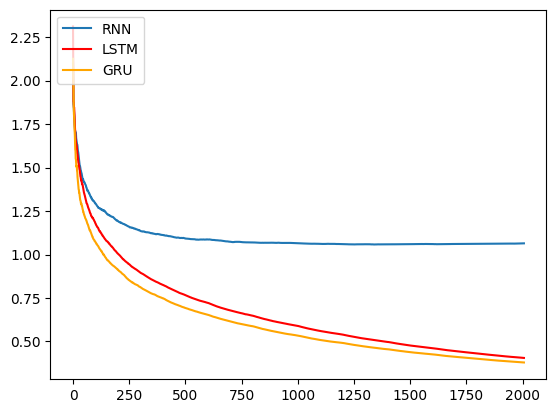

<Figure size 640x480 with 0 Axes>

<BarContainer object of 3 artists>

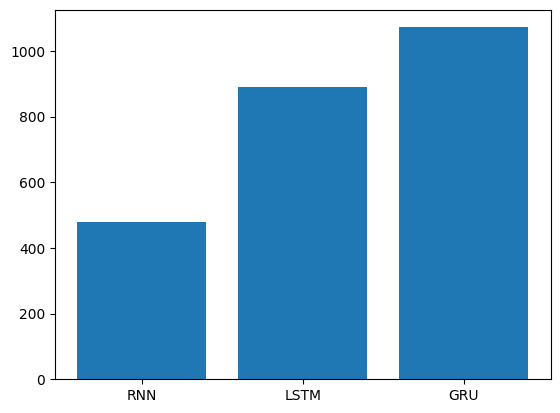

<Figure size 640x480 with 0 Axes>

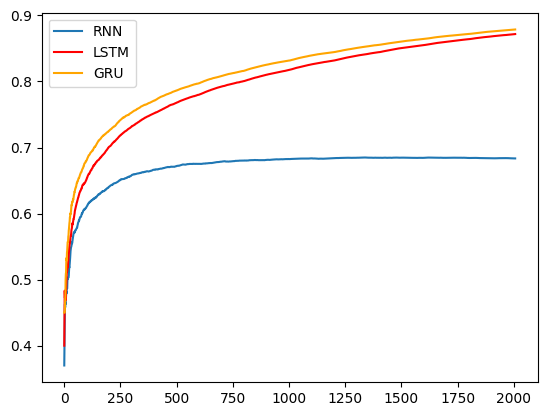

In [ ]:
#@title 绘制对比图
# 绘制损失对比曲线
# 创建画布0
plt.figure(0)
# # 绘制损失对比曲线
plt.plot(total_loss_list, label="RNN")
plt.plot(total_lloss_list, color="red", label="LSTM")
plt.plot(total_gloss_list, color="orange", label="GRU")
plt.legend(loc='upper left')
plt.savefig('RNN_LSTM_GRU_loss2.png')
plt.show()

# 绘制柱状图
# 创建画布1
plt.figure(1)
x_data = ["RNN", "LSTM", "GRU"]
y_data = [total_time, total_ltime, total_gtime]
# 绘制训练耗时对比柱状图
plt.bar(range(len(x_data)), y_data, tick_label=x_data)
plt.savefig('RNN_LSTM_GRU_period2.png')
plt.show()

# 绘制准确率对比曲线
plt.figure(2)
plt.plot(total_acc_list, label="RNN")
plt.plot(total_lacc_list, color="red", label="LSTM")
plt.plot(total_gacc_list, color="orange", label="GRU")
plt.legend(loc='upper left')
plt.savefig('RNN_LSTM_GRU_acc2.png')
plt.show()

In [34]:
#@title 预测结果
# 将人名转化为onehot张量
# eg 'bai' --> [3,57]
def NameToTensor(x):
  tensor_x = torch.zeros(len(x),n_letters)
  for i,letter in enumerate(x):
    tensor_x[i][all_letters.find(letter)] = 1
  return tensor_x

In [77]:
#@title RNN预测
def predict_rnn(x):
  # n_letters = n_letters # Removed to use global n_letters
  # n_hidden = 200 # Removed to use global n_hidden
  # n_countries = categorynum # Removed to use global n_countries

  x_tensor = NameToTensor(x)

  my_rnn = myRNN(input_size=n_letters, hidden_size=200, output_size=categorynum)
  my_rnn.load_state_dict(torch.load('/content/drive/MyDrive/NLP/model/my_rnn_model.bin'))
  my_rnn.eval()

  with torch.no_grad():
    output,hidden = my_rnn(x_tensor,my_rnn.inithidden())
    # Get the index of the highest probability
    topv,topi = torch.topk(output,k=3, dim=1)
    for i in range(3):
      country_idx = topi[0][i]
      country = categorys[country_idx]
      print("rnn-->",x)
      print(f"Predicted category: {country}")

In [37]:
#@title LSTM预测
def predict_lstm(x):
  # n_letters = n_letters # Removed to use global n_letters
  # n_hidden = 200 # Removed to use global n_hidden
  # n_countries = categorynum # Removed to use global n_countries

  x_tensor = NameToTensor(x)

  my_lstm = myLSTM(input_size=n_letters, hidden_size=200, output_size=categorynum)
  my_lstm.load_state_dict(torch.load('/content/drive/MyDrive/NLP/model/my_lstm_model.bin'))
  my_lstm.eval()

  with torch.no_grad():
    hidden,c = my_lstm.inithidden()
    output,hidden,c = my_lstm(x_tensor,hidden,c)
    # Get the index of the highest probability
    topi = torch.argmax(output, dim=1)
    country_idx = topi[0].item()
    country = categorys[country_idx]
    print("lstm-->",x) # Changed from rnn--> to lstm--> for clarity
    print(f"Predicted category: {country}")

In [38]:
#@title GRU预测
def predict_gru(x):
  # n_letters = n_letters # Removed to use global n_letters
  # n_hidden = 200 # Removed to use global n_hidden
  # n_countries = categorynum # Removed to use global n_countries

  x_tensor = NameToTensor(x)

  my_gru = myGRU(input_size=n_letters, hidden_size=200, output_size=categorynum)
  my_gru.load_state_dict(torch.load('/content/drive/MyDrive/NLP/model/my_GRU_model.bin'))
  my_gru.eval()

  with torch.no_grad():
    output,hidden = my_gru(x_tensor,my_gru.inithidden())
    # Get the index of the highest probability
    topi = torch.argmax(output, dim=1)
    country_idx = topi[0].item()
    country = categorys[country_idx]
    print("gru-->",x) # Changed from rnn--> to gru--> for clarity
    print(f"Predicted category: {country}")

In [80]:
predict_rnn("Alien")

rnn--> Alien
Predicted category: English
rnn--> Alien
Predicted category: Russian
rnn--> Alien
Predicted category: German


In [86]:
#@title 预测调用
def dm_test_predic_rnn_lstm_gru():
        # 把三个函数的入口地址 组成列表，统一输入数据进行测试
    for func in [predict_rnn, predict_lstm, predict_gru]:
        func('Jian')

dm_test_predic_rnn_lstm_gru()

rnn--> Jian
Predicted category: Russian
rnn--> Jian
Predicted category: English
rnn--> Jian
Predicted category: Chinese
lstm--> Jian
Predicted category: Chinese
gru--> Jian
Predicted category: Chinese


In [28]:
import torch

if torch.cuda.is_available():
    device_count = torch.cuda.device_count()
    print(f"Number of CUDA devices: {device_count}")
    for i in range(device_count):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")
        properties = torch.cuda.get_device_properties(i)
        print(f"  CUDA Capability: {properties.major}.{properties.minor}")
        print(f"  Total memory: {properties.total_memory / (1024**3):.2f} GB")
        print(f"  Multiprocessors: {properties.multi_processor_count}")
        print(f"  Max threads per multiprocessor: {properties.max_threads_per_multi_processor}")
else:
    print("CUDA is not available.")

CUDA is not available.
